<h1>Model: Female Anger vs. Others</h1>

In [35]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [36]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict
from PIL import Image

<h2>Data Loading and Preparation</h2>

In [37]:
def getEmotionCode(x):
    part = x.split('_')
    if part[3] == 'ANG':
        return 1
    else:
        return 0

def getEmotion(x):
    if x == 1:
        return 'ANG'
    else:
        return 'NEU'

In [38]:
X_all = []
Y_all = []

image_folder_path = 'cremad/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    split_file_name = file_name.split('_')
    if split_file_name[0] == 'M' and (split_file_name[3] in ['ANG','NEU']):
        spectrogram = Image.open(image_folder_path + '/' + file_name)
        spectrogram = spectrogram.convert('L')
        spectrogram = spectrogram.resize((167, 109))
        spectrogram = np.array(spectrogram)
        spectrogram = np.expand_dims(spectrogram, axis=2)
        X_all.append(spectrogram)
        Y_all.append(getEmotionCode(file_name))
    
#print(X_all)
#print(Y_all)


In [39]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=2)

#print(X_all)
#print(Y_all)

(1246, 109, 167, 1)
(1246,)


In [40]:
# train /test= 80/20% split
# stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 123, stratify=Y_all)



<h2>Model Building</h2>

In [41]:
def build_current_model():
    inp = Input(shape=(109, 167,1))
    
    c1 = Convolution2D(filters=128,kernel_size=(5,5),strides=(2,2),padding='same')(inp)
    bt = BatchNormalization()(c1)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.2)(mpool)

    
    c2 = Convolution2D(filters=256,kernel_size=(4,4),strides=(2,2),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.3)(mpool)
    
    c2 = Convolution2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.3)(mpool)
    
    c3 = Convolution2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c3)
    bt = Activation('relu')(bt)
    #bt = LeakyReLU(alpha=0.01)(bt)
    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.4)(mpool)
    
    f = Flatten()(mpool)
    
    x_dense = Dense(2048)(f)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.4)(bt)

    
    x_dense = Dense(2048)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.3)(bt)
    
    x_dense = Dense(512)(bt)
    bt = BatchNormalization()(x_dense)
    bt = Activation('relu')(bt)
    bt = Dropout(0.2)(bt)

    x_out = Dense(2, name='output', activation='softmax')(bt)
    
    model = Model(inputs=inp, outputs=x_out)
    model.compile(optimizer=Adam(lr=0.0005), 
                  loss='categorical_crossentropy', 
                  metrics = ['accuracy'])
    return model


In [42]:
model = build_current_model()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 109, 167, 1)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 55, 84, 128)       3328      
_________________________________________________________________
batch_normalization_14 (Batc (None, 55, 84, 128)       512       
_________________________________________________________________
activation_14 (Activation)   (None, 55, 84, 128)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 42, 128)       0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 28, 42, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 21, 256)       5245

In [43]:
#tf.keras.utils.plot_model(model, "Model-Ref7Var.png", show_shapes=True)

In [44]:
from tensorflow.keras.callbacks import TensorBoard
import time

name = "MaleAngerNeu-{}".format(time.time())
print(name)
tensorboard = TensorBoard(log_dir="logs/{}".format(name))

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 patience=50,
                                                 verbose=1, 
                                                 mode='min',
                                                 restore_best_weights=True)

my_callbacks = [early_stop, tensorboard]

history = model.fit(X_train, Y_train, 
              epochs = 500, 
              validation_split=0.1, 
              verbose=1, 
              batch_size = 8,
              callbacks=my_callbacks)

history_info = history.history

MaleAngerNeu-1590786884.3911152
Train on 896 samples, validate on 100 samples
Epoch 1/500
896/896 [==============================] - 2s 3ms/sample - loss: 0.6640 - acc: 0.7623 - val_loss: 1.8432 - val_acc: 0.6200
Epoch 2/500
896/896 [==============================] - 2s 2ms/sample - loss: 0.4730 - acc: 0.8170 - val_loss: 1.4890 - val_acc: 0.3800
Epoch 3/500
896/896 [==============================] - 2s 2ms/sample - loss: 0.3915 - acc: 0.8259 - val_loss: 0.3758 - val_acc: 0.8600
Epoch 4/500
896/896 [==============================] - 2s 2ms/sample - loss: 0.3588 - acc: 0.8460 - val_loss: 0.5051 - val_acc: 0.7300
Epoch 5/500
896/896 [==============================] - 2s 2ms/sample - loss: 0.3500 - acc: 0.8627 - val_loss: 0.5534 - val_acc: 0.6500
Epoch 6/500
896/896 [==============================] - 2s 2ms/sample - loss: 0.3112 - acc: 0.8739 - val_loss: 1.4407 - val_acc: 0.5800
Epoch 7/500
896/896 [==============================] - 2s 2ms/sample - loss: 0.3458 - acc: 0.8705 - val_loss: 0.

Epoch 61/500
896/896 [==============================] - 2s 2ms/sample - loss: 0.1411 - acc: 0.9598 - val_loss: 2.0050 - val_acc: 0.7800
Epoch 62/500
896/896 [==============================] - 2s 2ms/sample - loss: 0.1273 - acc: 0.9643 - val_loss: 0.4465 - val_acc: 0.8400
Epoch 63/500
896/896 [==============================] - 2s 2ms/sample - loss: 0.0888 - acc: 0.9754 - val_loss: 0.4030 - val_acc: 0.8500
Epoch 64/500
896/896 [==============================] - 2s 2ms/sample - loss: 0.1106 - acc: 0.9699 - val_loss: 2.8152 - val_acc: 0.5100
Epoch 65/500
896/896 [==============================] - 2s 2ms/sample - loss: 0.0859 - acc: 0.9721 - val_loss: 0.3683 - val_acc: 0.8800
Epoch 66/500
896/896 [==============================] - 2s 2ms/sample - loss: 0.0779 - acc: 0.9732 - val_loss: 0.3535 - val_acc: 0.8500
Epoch 67/500
896/896 [==============================] - 2s 2ms/sample - loss: 0.0610 - acc: 0.9855 - val_loss: 0.3928 - val_acc: 0.8200
Epoch 68/500
896/896 [==========================

896/896 [==============================] - 2s 2ms/sample - loss: 0.0844 - acc: 0.9855 - val_loss: 0.7764 - val_acc: 0.8500
Epoch 122/500
896/896 [==============================] - 2s 2ms/sample - loss: 0.0169 - acc: 0.9967 - val_loss: 0.4367 - val_acc: 0.8900
Epoch 123/500
896/896 [==============================] - 2s 2ms/sample - loss: 0.0358 - acc: 0.9933 - val_loss: 0.4518 - val_acc: 0.8900
Epoch 124/500
896/896 [==============================] - 2s 2ms/sample - loss: 0.0427 - acc: 0.9888 - val_loss: 1.1292 - val_acc: 0.8100
Epoch 125/500
896/896 [==============================] - 2s 2ms/sample - loss: 0.0340 - acc: 0.9900 - val_loss: 0.5425 - val_acc: 0.8900
Epoch 126/500
896/896 [==============================] - 2s 2ms/sample - loss: 0.0899 - acc: 0.9833 - val_loss: 0.4202 - val_acc: 0.8900
Epoch 127/500
896/896 [==============================] - 2s 2ms/sample - loss: 0.0287 - acc: 0.9911 - val_loss: 0.4319 - val_acc: 0.9200
Epoch 128/500
896/896 [==============================] 

<h2>Evaluation (Basic)</h2>

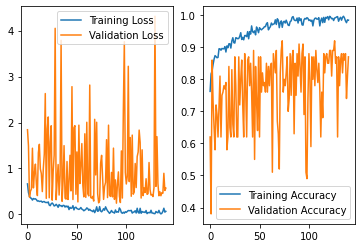

In [45]:
## Loss and accuracy history
_, axs = plt.subplots(ncols=2)
df_history_info = pd.DataFrame(history_info) 


sns.lineplot(data=df_history_info['loss'],ax=axs[0], label='Training Loss', legend='brief')
sns.lineplot(data=df_history_info['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

sns.lineplot(data=df_history_info['acc'],ax=axs[1], label='Training Accuracy', legend='brief')
sns.lineplot(data=df_history_info['val_acc'],ax=axs[1], label='Validation Accuracy', legend='brief')

In [46]:
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

[[121  14]
 [ 16  99]]


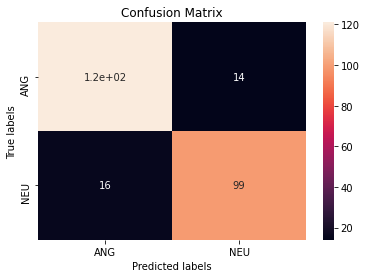

In [47]:
Y_pred = model.predict(X_test)
actual, predicted = generate_actual_predicted(Y_pred, X_test, Y_test)

##Confusion Matrix
from sklearn.metrics import confusion_matrix
actual_labeled = list()
predict_labeled = list()
for x,y in zip(actual,predicted):
    actual_labeled.append(getEmotion(x))
    predict_labeled.append(getEmotion(y))

labels = ['ANG','NEU']
cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

In [48]:
## Test accuracy
from sklearn.metrics import accuracy_score
print('accuracy', accuracy_score(actual, predicted))


accuracy 0.88


In [49]:
## Precision, Recall, F1, Support
from sklearn.metrics import classification_report
print(classification_report(actual_labeled, predict_labeled,labels=labels))

              precision    recall  f1-score   support

         ANG       0.88      0.90      0.89       135
         NEU       0.88      0.86      0.87       115

    accuracy                           0.88       250
   macro avg       0.88      0.88      0.88       250
weighted avg       0.88      0.88      0.88       250



In [50]:
##ROC AUC Scores
#from sklearn.metrics import roc_auc_score
#print('One-vs-One ROC AUC scores:')
#print(roc_auc_score(actual, Y_pred, average='macro', multi_class='ovo'), '(macro)')
#print(roc_auc_score(actual, Y_pred, average='weighted', multi_class='ovo'), '(weighted by prevalence)')


#print()
#print('One-vs-Rest ROC AUC scores:')
#print(roc_auc_score(actual, Y_pred, average='macro', multi_class='ovr'), '(macro)')
#print(roc_auc_score(actual, Y_pred, average='weighted', multi_class='ovr'), '(weighted by prevalence)')

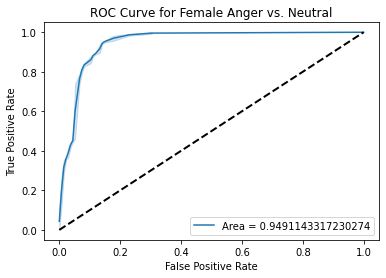

In [51]:
## ROC Curves
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from scipy import interp

### The following curves are generated s.t each point is a model from differing thresholds

_, axs = plt.subplots(ncols=1)
axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve for Female Anger vs. Neutral')


fpr, tpr, _ = roc_curve(Y_test[:,0], Y_pred[:,0])
auc_val = auc(fpr, tpr)
sns.lineplot(x=fpr,y=tpr,ax=axs, label='Area = ' + str(auc_val) + '', legend='brief')


plt.plot([0, 1], [0, 1], 'k--', lw=2)

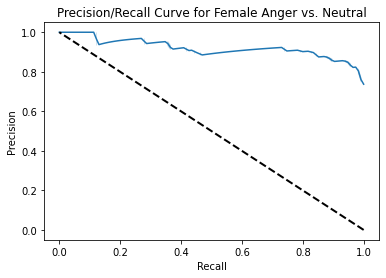

In [52]:
## Precision/Recall Curves per class
### The following curves are generated s.t each point is a model from differing thresholds
from sklearn.metrics import precision_recall_curve

_, axs = plt.subplots(ncols=1)
axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve for Female Anger vs. Neutral')

prec, rec, _ = precision_recall_curve(Y_test[:,0], Y_pred[:,0])
sns.lineplot(x=rec,y=prec,ax=axs)

# Diagonal line for comparison
plt.plot([1, 0], [0, 1], 'k--', lw=2)

<h2>K-Fold Training and Evaluation</h2>

In [ ]:
#Precision Mean and Standard Deviation
#Recall Mean and Standard Deviation
#F1 Measure Mean and Standard Deviation
#True Positive Rate. Mean and Standard Deviation
#False Negative Rate Mean and Standard Deviation
#Best/Worst ROC
#Best/Worst Precision/Recall
#Accuracy Mean and Standard Deviation

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()

all_accuracy = list()


n_split=3
for train_index,test_index in KFold(n_split).split(X_all):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]

    # create and fit the model
    cv_model=build_current_model()
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=30,
              validation_split=0.1,
              verbose=1)
    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')

    
    curr_fpr = [0] * 6
    curr_tpr = [0] * 6
    for i in range(6):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * 6
    curr_rec = [0] * 6
    for i in range(6):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    
    


In [ ]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



In [ ]:
# Plot all K-Fold ROC curves
for i in range(3):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(6):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getEmotion(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

In [ ]:
#Plot all K-Fold Precision/Recall curves
for i in range(3):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(6):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getEmotion(j), legend='brief')

<h2>Storing/Loading history and model to file</h2>

In [ ]:
#Store History
hist_df = pd.DataFrame(history.history) 
hist_json_file = 'ref7varhistory.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [ ]:
#Load History 
history_info = pd.read_json('history.json')

In [ ]:
##Save Model
model.save('ref7var_trained.model') #Save the model

In [ ]:
## Load Model
model = tf.keras.models.load_model('mobile_net_trained.model') #Re load model